In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats
import statsmodels.api as sm

In [133]:
url = 'https://media.githubusercontent.com/media/musanchez/DataSets/refs/heads/main/realtor-data.csv'
df = pd.read_csv(url)

df.head() # Verificamos que el dataset se haya cargado correctamente


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.00,for_sale,105000.00,3.00,2.00,0.12,1962661.00,Adjuntas,Puerto Rico,601.00,920.00,NaN
1,52707.00,for_sale,80000.00,4.00,2.00,0.08,1902874.00,Adjuntas,Puerto Rico,601.00,1527.00,NaN
2,103379.00,for_sale,67000.00,2.00,1.00,0.15,1404990.00,Juana Diaz,Puerto Rico,795.00,748.00,NaN
3,31239.00,for_sale,145000.00,4.00,2.00,0.10,1947675.00,Ponce,Puerto Rico,731.00,1800.00,NaN
4,34632.00,for_sale,65000.00,6.00,2.00,0.05,331151.00,Mayaguez,Puerto Rico,680.00,NaN,NaN


,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,2221849.00,2224841.00,1745065.00,1714611.00,1900793.00,2215516.00,2226083.00,1657898.00
mean,52939.89,524195.52,3.28,2.50,15.22,1012324.92,52186.68,2714.47
std,30642.75,2138893.22,1.57,1.65,762.82,583763.48,28954.08,808163.52
min,0.00,0.00,1.00,1.00,0.00,0.00,0.00,4.00
25%,23861.00,165000.00,3.00,2.00,0.15,506312.75,29617.00,1300.00
50%,52884.00,325000.00,3.00,2.00,0.26,1012765.50,48382.00,1760.00
75%,79183.00,550000.00,4.00,3.00,0.98,1521173.25,78070.00,2413.00
max,110142.00,2147483600.00,473.00,830.00,100000.00,2001357.00,99999.00,1040400400.00


brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64
brokered_by       0.20
status            0.00
price             0.07
bed              21.62
bath             22.99
acre_lot         14.62
street            0.49
city              0.06
state             0.00
zip_code          0.01
house_size       25.53
prev_sold_date   32.98
dtype: float64


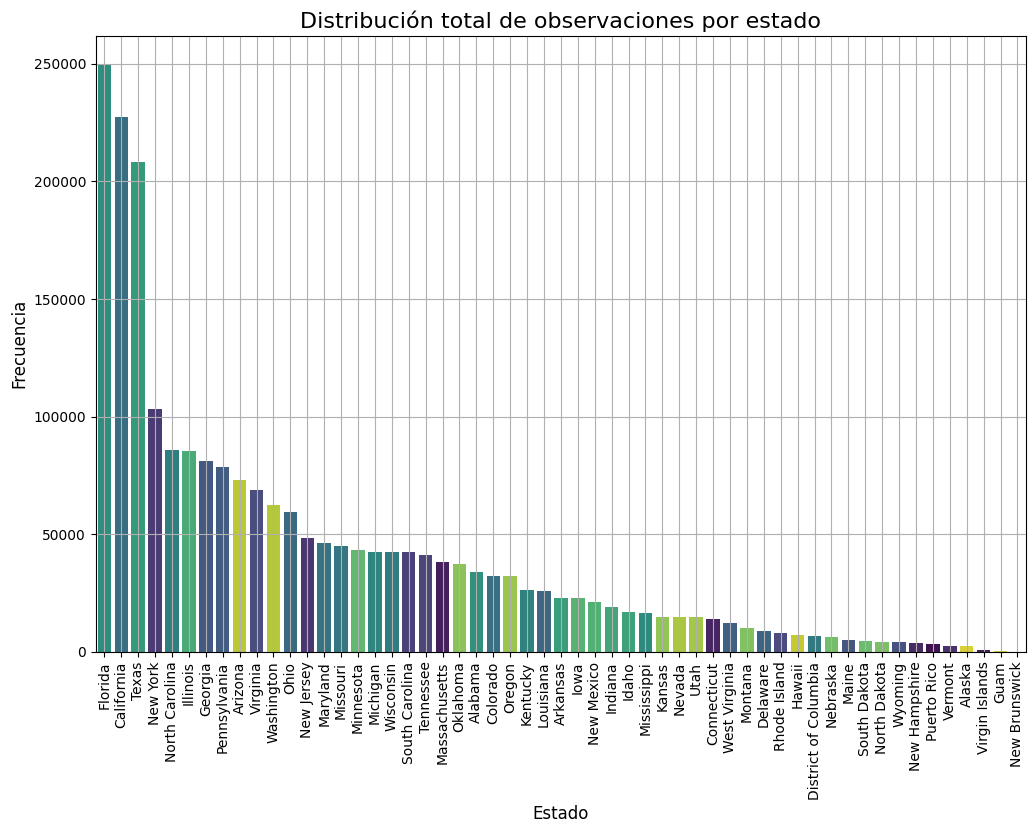

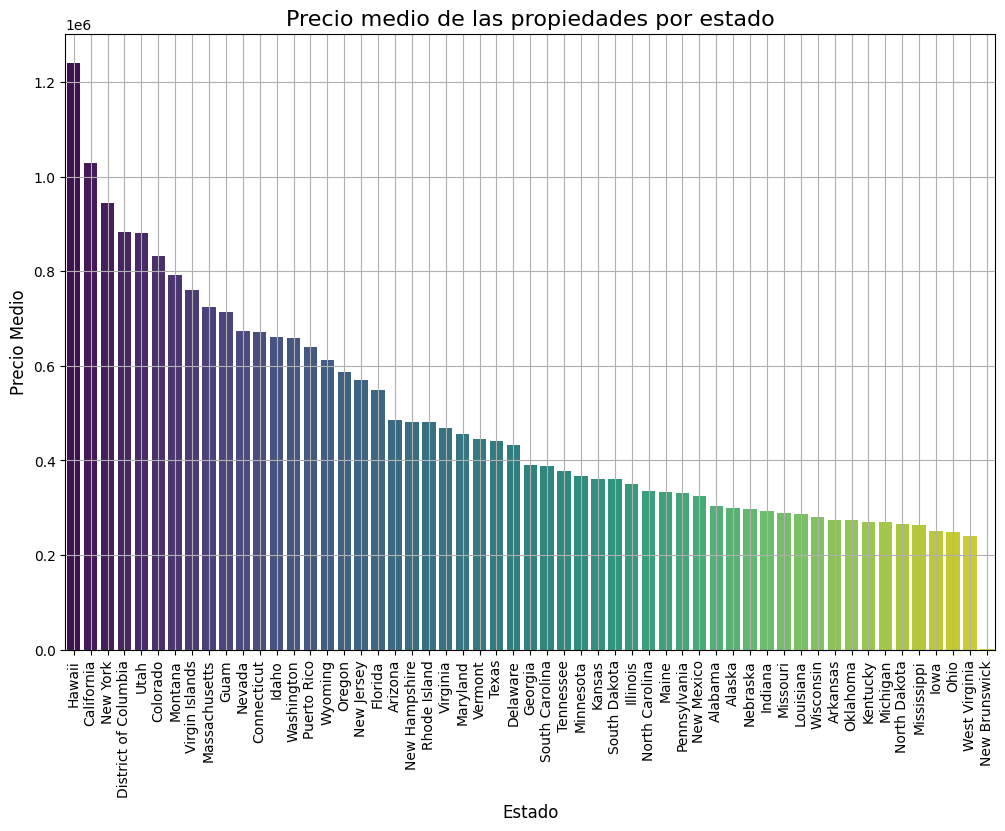

In [134]:
# Estadísticas descriptivas
# Evita que aparezcan los exponenciales y poder apreciar mejor el dataset
def set_overview(df):
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    display(df.describe())
    print(df.isna().sum()) # Verificamos si hay datos nulos
    print(df.isna().mean() * 100) # Observamos de manera porcentual los datos nulos

# Haremos un grafico de caja para cada variable numérica, le pasaremos el dataframe y todas las variables numéricas
def box_plot_vars(df):
    # Filtrar automáticamente solo las columnas numéricas
    numeric_vars = df.select_dtypes(include=['number']).columns
    for var in numeric_vars:
        plt.figure(figsize=(10, 6))  # Ajustar tamaño del gráfico
        sns.boxplot(x=df[var], color='lightblue', 
                    flierprops={'marker':'o', 'markerfacecolor':'red', 'markersize':8})  # Color del boxplot y marcar outliers
        
        # Título y etiquetas
        plt.title(f'Box Plot for {var}', fontsize=16)  # Agregar título con el nombre de la variable
        plt.xlabel(var, fontsize=12)  # Etiqueta del eje X
        plt.ylabel('Valores', fontsize=12)  # Etiqueta del eje Y (opcional)
        
        # Quitar notación científica en el eje X
        plt.ticklabel_format(style='plain', axis='x')
        # Si se necesitan también quitar los exponentes en el eje Y, descomenta la línea de abajo:
        # plt.ticklabel_format(style='plain', axis='y')
        
        plt.grid(True)  # Añadir rejilla
        plt.show()

def remove_outliers_iqr(df, column_name):

    if isinstance(df[column_name], np.ma.MaskedArray):
        df[column_name] = df[column_name].data

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[column_name] >= (Q1 - 1.5 * IQR)) & (df[column_name] <= (Q3 + 1.5 * IQR))]
    return df

def plot_correlation_matrix(df):
    df_numeric = df.select_dtypes(include=['number'])
    
    plt.figure(figsize=(10, 8))
    correlation_matrix = df_numeric.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix', fontsize=16)
    plt.show()

def plot_histograms(df, columns):
    for col in columns:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.title(f'Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(True)
        plt.show()

def plot_state_distribution(df, column, title):
    plt.figure(figsize=(12, 8))
    sns.countplot(data=df, x=column, hue=column, order=df[column].value_counts().index, palette='viridis', dodge=False)
    plt.title(title, fontsize=16)
    plt.xlabel('Estado', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend([], [], frameon=False)  # Ocultar leyenda
    plt.show()

def plot_average_price_per_state(df):
    avg_price_per_state = df.groupby('state')['price'].mean().reset_index()
    avg_price_per_state = avg_price_per_state.sort_values(by='price', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=avg_price_per_state, x='state', y='price', hue='state', palette='viridis', dodge=False)
    plt.title('Precio medio de las propiedades por estado', fontsize=16)
    plt.xlabel('Estado', fontsize=12)
    plt.ylabel('Precio Medio', fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend([], [], frameon=False)  # Ocultar leyenda
    plt.show()

set_overview(df)
plot_state_distribution(df, 'state', 'Distribución total de observaciones por estado')
plot_average_price_per_state(df)
#Observamos de manera porcentual los datos nulos
# Las columnas brokered by, street, zip_code realmente no aportan información relevante para el análisis.
# Notamos datos extraños, por ejemplo, bed es el número de habitaciones y el valor máximo es de 473, sin sentido.
# Lo mismo podemos notar en el caso de bath, que es el número de baños y el valor máximo es de 830.

In [135]:
# Limpieza de datos

# Eliminamos registros de casas sin precio
df_cleaned = df.dropna(subset=['price']).copy()
df_cleaned.drop_duplicates(inplace=True)

df_cleaned['prev_sold_date'] = df_cleaned['prev_sold_date'].fillna('Not sold before')

df_cleaned = df_cleaned.drop(columns=['brokered_by', 'street', 'zip_code'])

# Eliminamos columnas que tengan demasiados valores nulos
df_cleaned = df_cleaned[df_cleaned.isna().sum(axis=1) < 0.5 * len(df_cleaned.columns)]

# Asigna la cantidad de baños promedios por cantidad de habitaciones
# Hacemos esto para la limpieza, así imputar valores faltantes.
bath_avg_bed = df.groupby('bed')['bath'].mean().round(0).reset_index()
bath_avg_bed.columns = ['bed', 'bath_avg']

# Vamos a llenar los valores faltantes de bath con el promedio de baños por cantidad de habitaciones
# Agregamos al cleaned set la columna con el promedio de baños por cantidad de habitaciones
df_cleaned = df_cleaned.merge(bath_avg_bed, on='bed', how='left')
df_cleaned['bath'] = df_cleaned['bath'].fillna(df_cleaned['bath_avg'])

# Eliminamos la columna de promedio de baños por cantidad de habitaciones, ya no se necesita
df_cleaned = df_cleaned.drop(columns='bath_avg')

# Imputamos valores faltantes en bed
df_cleaned = df_cleaned.fillna(df_cleaned['bed'].median())

set_overview(df_cleaned)


,price,bed,bath,acre_lot,house_size
count,2224832.00,2224832.00,2224832.00,2224832.00,2224832.00
mean,524186.41,3.22,2.61,13.43,2022.72
std,2138839.50,1.39,1.48,705.06,697638.00
min,0.00,1.00,1.00,0.00,3.00
25%,165000.00,3.00,2.00,0.17,3.00
50%,325000.00,3.00,3.00,0.35,1442.00
75%,550000.00,4.00,3.00,3.00,2140.00
max,2147483600.00,473.00,830.00,100000.00,1040400400.00


status            0
price             0
bed               0
bath              0
acre_lot          0
city              0
state             0
house_size        0
prev_sold_date    0
dtype: int64
status           0.00
price            0.00
bed              0.00
bath             0.00
acre_lot         0.00
city             0.00
state            0.00
house_size       0.00
prev_sold_date   0.00
dtype: float64


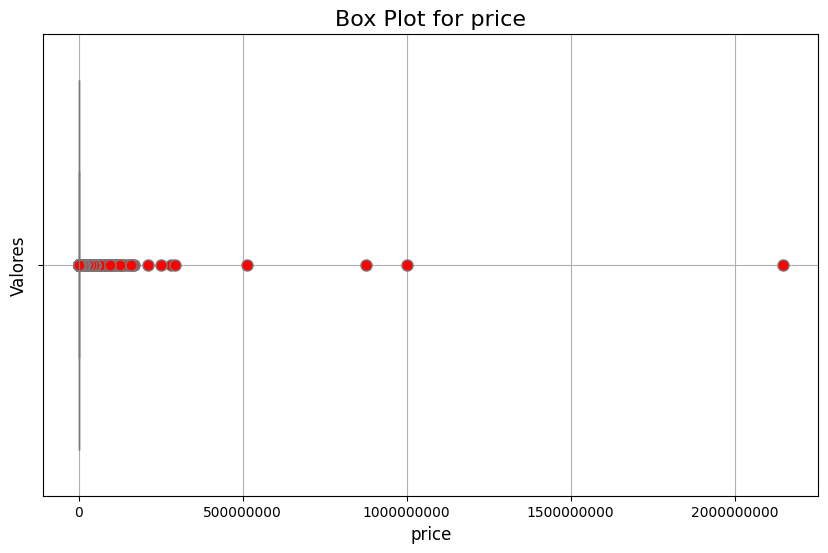

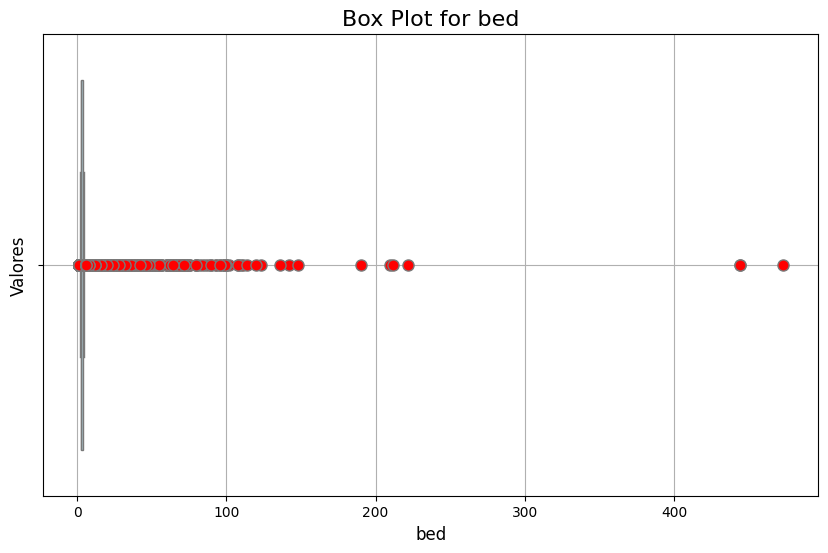

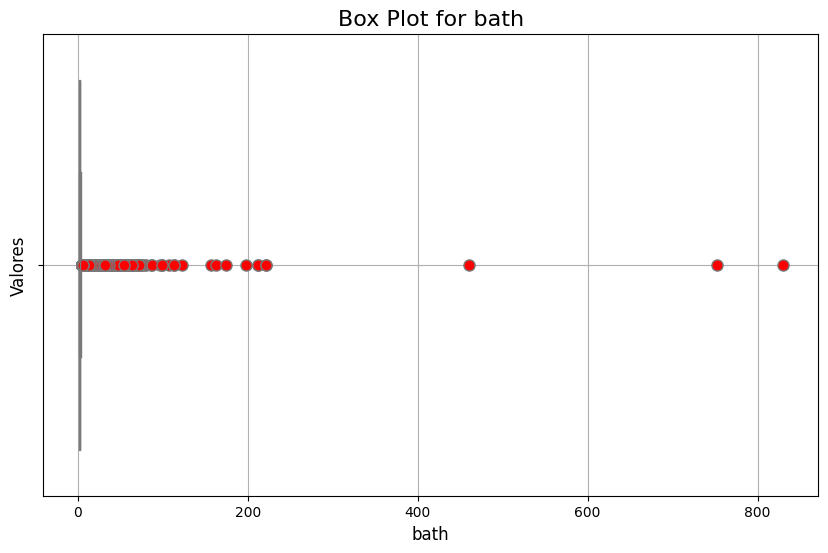

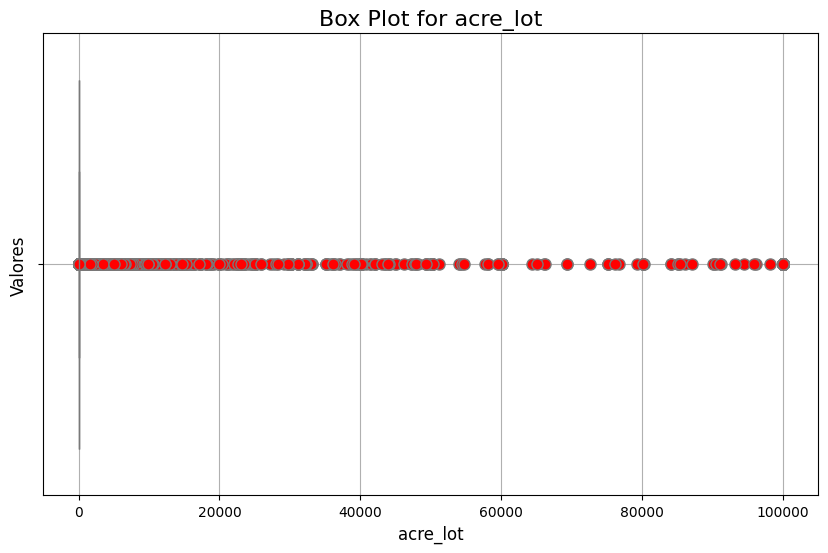

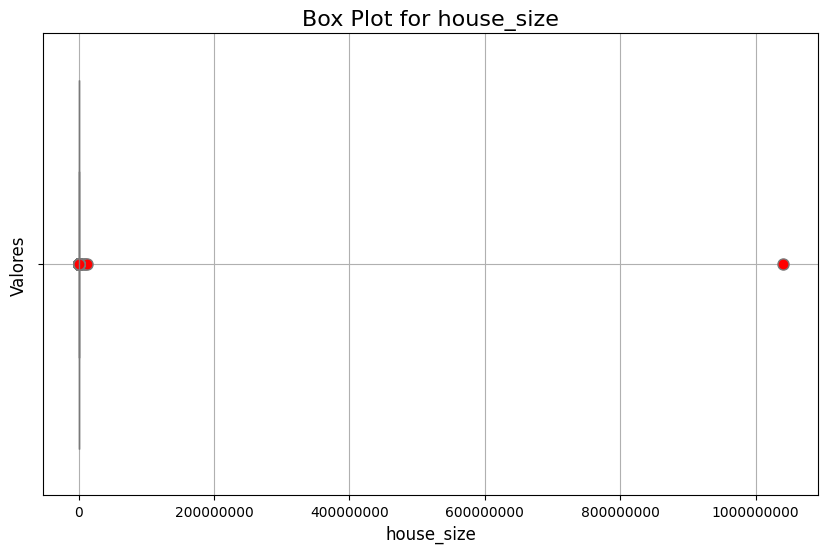

In [136]:
# Eliminación de outliers
box_plot_vars(df_cleaned)

In [137]:
# Eliminar valores que claramente son absurdos
# Segun san google, la casa mas pequeña del mundo es de 325 pies cuadrados, no puede ser que haya casas con 3 pies cuadrados
df_cleaned = df_cleaned[(df_cleaned['bed'] != 0) & (df_cleaned['bath'] != 0) & (df_cleaned['price'] > 0) & (df_cleaned['house_size'] > 500)]
# Eliminamos datos en los que el tamaño del lote es menor que el tamaño de la casa
df_cleaned = df_cleaned[df_cleaned['acre_lot'] * 43560 >= df_cleaned['house_size']]

df_cleaned = df_cleaned[df_cleaned['state'] != 3.0]
df_cleaned['state'] = df_cleaned['state'].astype(str)


df_cleaned['log_house_size'] = np.log(df_cleaned['house_size'])

df_cleaned = remove_outliers_iqr(df_cleaned, 'house_size')
df_cleaned = remove_outliers_iqr(df_cleaned, 'bath')
df_cleaned = remove_outliers_iqr(df_cleaned, 'bed')
df_cleaned = remove_outliers_iqr(df_cleaned, 'acre_lot')


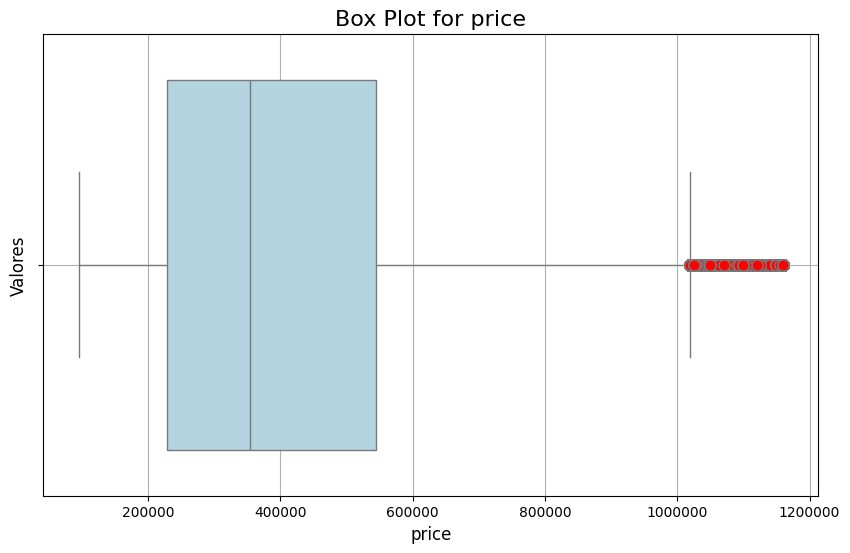

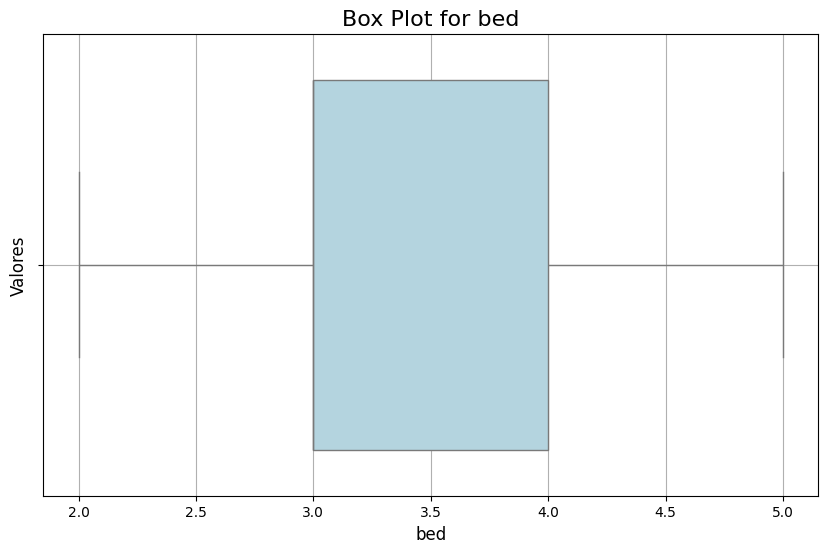

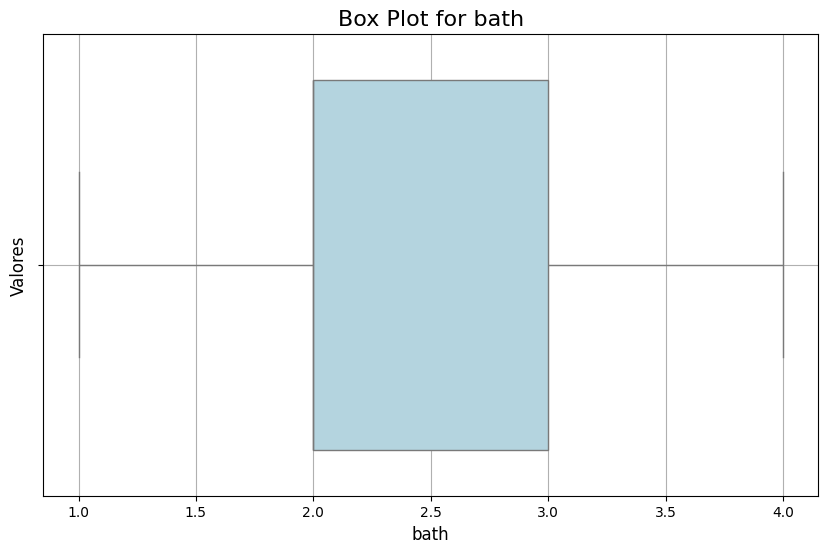

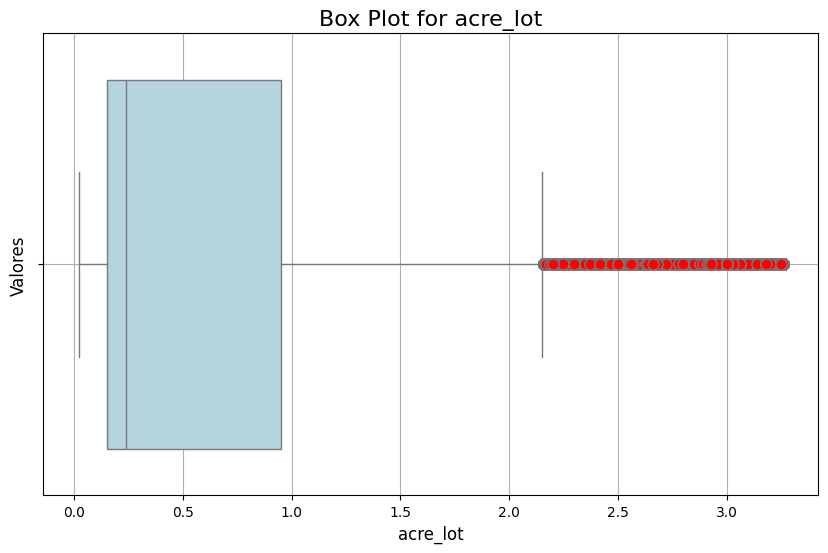

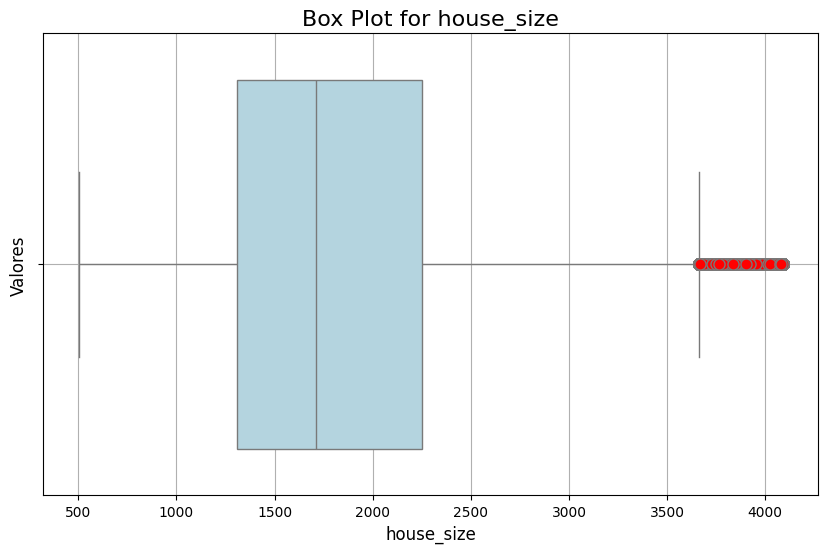

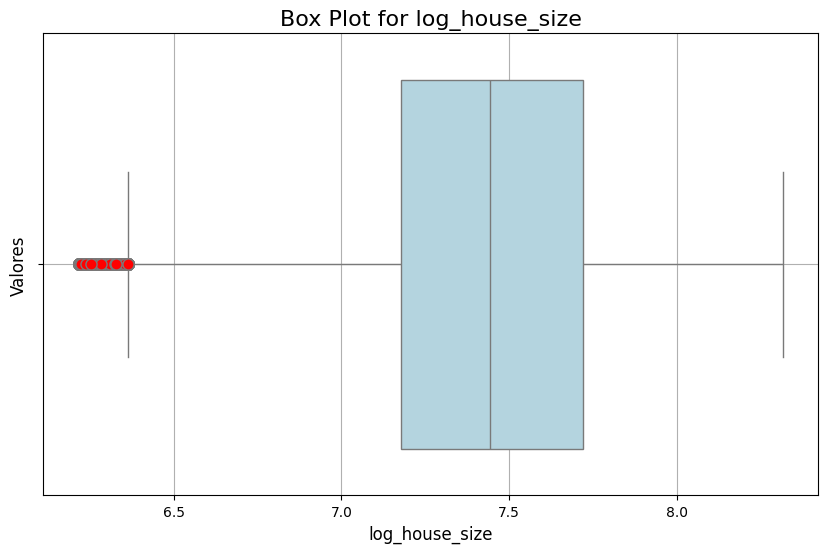

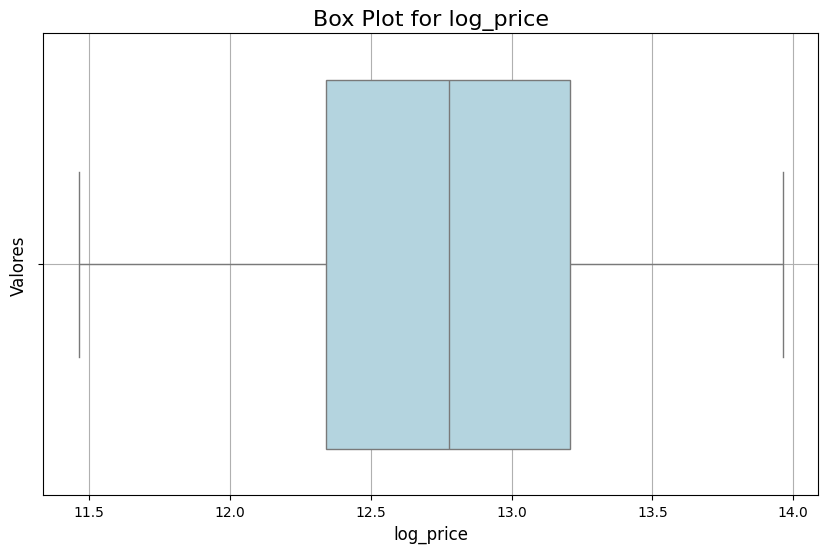

In [138]:
df_cleaned['price'] = mstats.winsorize(df_cleaned['price'], limits=[0.05, 0.05])
df_cleaned['log_price'] = np.log(df_cleaned['price'])
#df_cleaned = df_cleaned.drop(columns=['price', 'house_size', 'acre_lot'])
box_plot_vars(df_cleaned)

In [139]:
print(df.shape)
print(df_cleaned.shape)
set_overview(df_cleaned)
df_cleaned = df_cleaned.drop(columns=['city'])

(2226382, 12)
(1351305, 11)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:4809: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:4809: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:4809: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:4809: UserWa

,price,bed,bath,acre_lot,house_size,log_house_size,log_price
count,1351305.00,1351305.00,1351305.00,1351305.00,1351305.00,1351305.00,1351305.00
mean,424779.35,3.18,2.33,0.82,1839.73,7.45,12.76
std,273683.86,0.80,0.80,1.08,695.87,0.38,0.65
min,95000.00,2.00,1.00,0.02,501.00,6.22,11.46
25%,229000.00,3.00,2.00,0.15,1309.00,7.18,12.34
50%,353995.00,3.00,2.00,0.24,1710.00,7.44,12.78
75%,545000.00,4.00,3.00,0.95,2251.00,7.72,13.21
max,1160000.00,5.00,4.00,3.26,4091.00,8.32,13.96


status            0
price             0
bed               0
bath              0
acre_lot          0
city              0
state             0
house_size        0
prev_sold_date    0
log_house_size    0
log_price         0
dtype: int64
status           0.00
price            0.00
bed              0.00
bath             0.00
acre_lot         0.00
city             0.00
state            0.00
house_size       0.00
prev_sold_date   0.00
log_house_size   0.00
log_price        0.00
dtype: float64


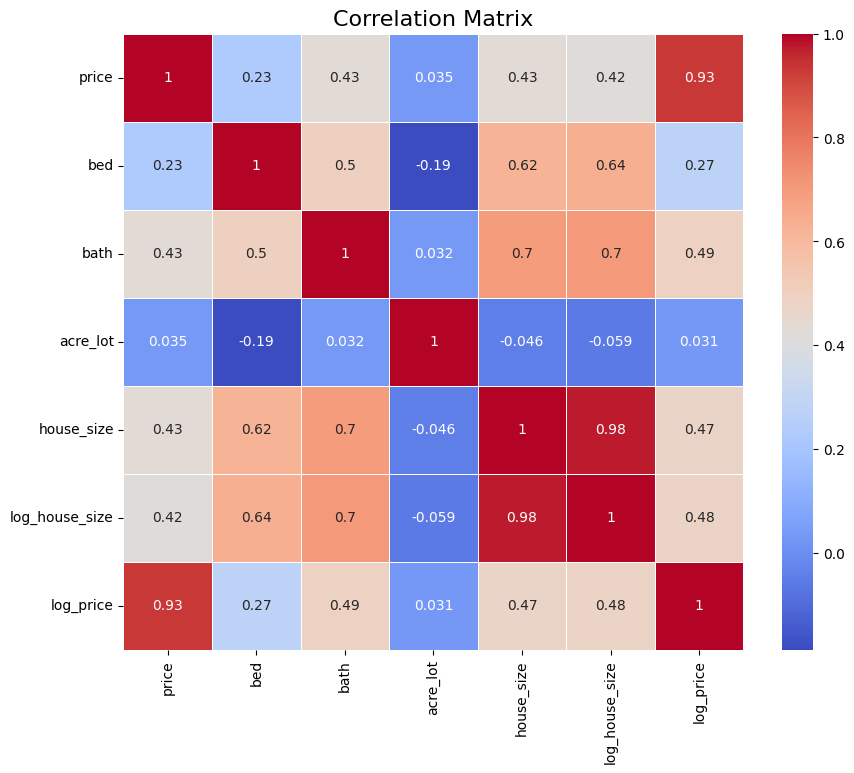

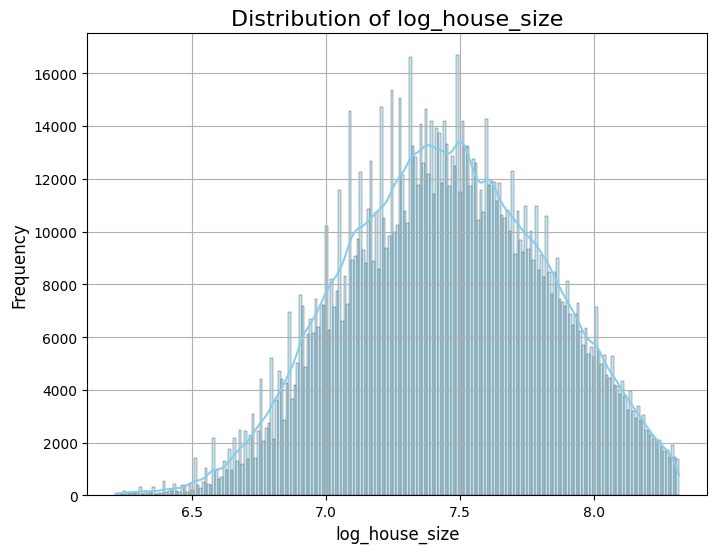

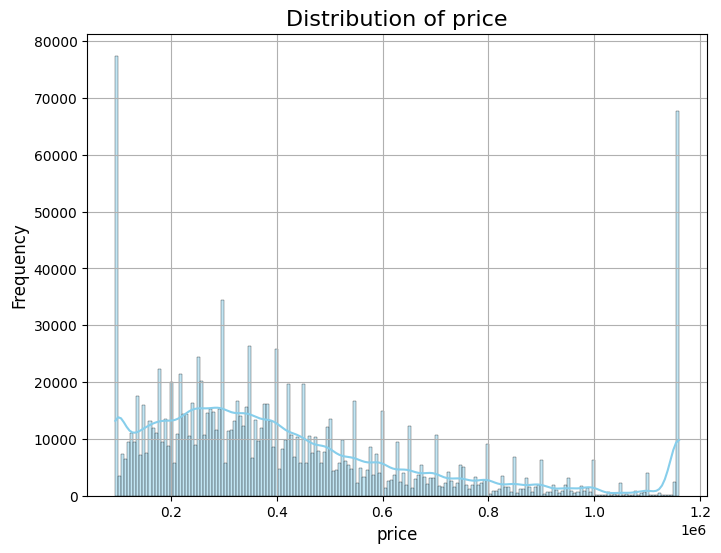

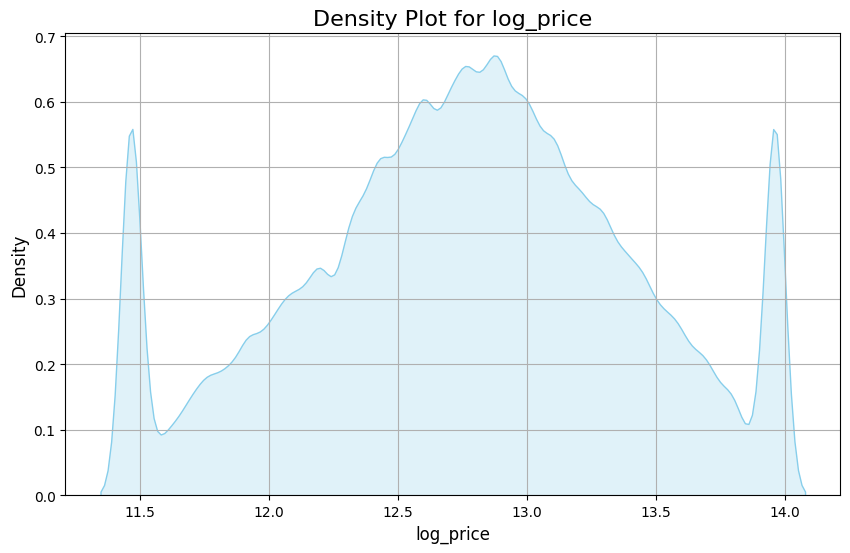

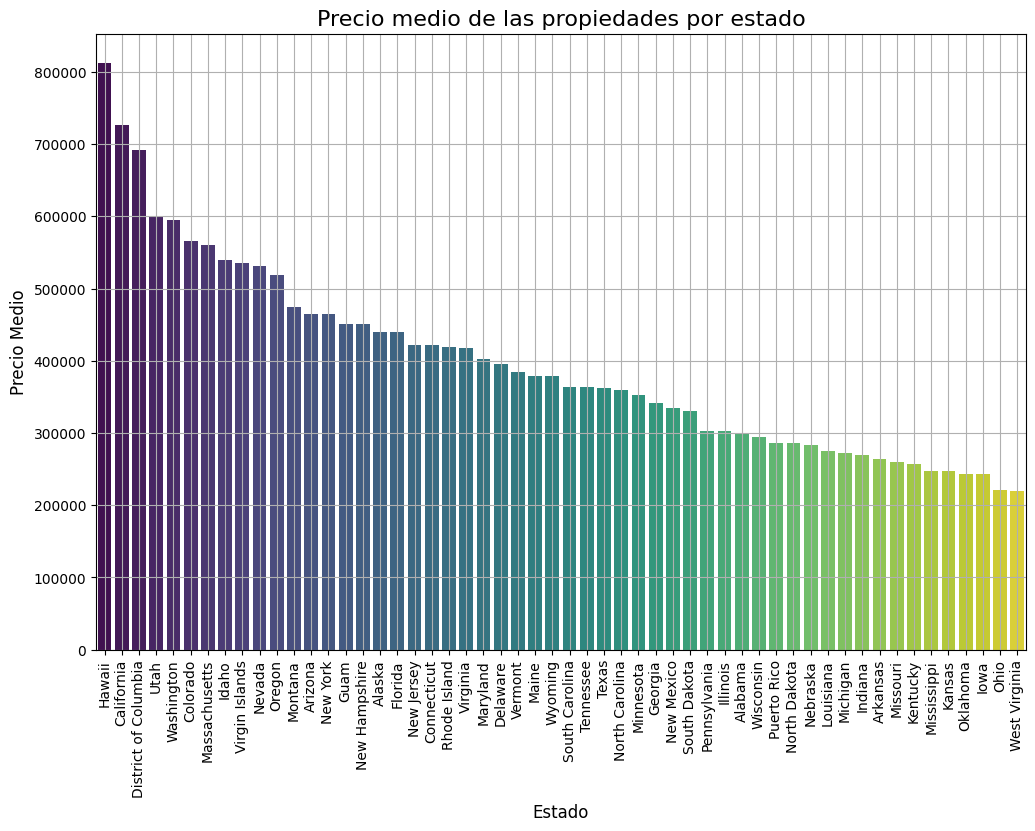

In [140]:
plot_correlation_matrix(df_cleaned)
col = ['log_house_size', 'price']

plot_histograms(df_cleaned, col)

plt.figure(figsize=(10, 6))
sns.kdeplot(df_cleaned['log_price'], fill=True, color='skyblue')
plt.title('Density Plot for log_price', fontsize=16)
plt.xlabel('log_price', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.show()

plot_average_price_per_state(df_cleaned)

,price,log_price,state
1,95000.00,11.46,Puerto Rico
2,95000.00,11.46,Puerto Rico
6,95000.00,11.46,Puerto Rico
7,95000.00,11.46,Puerto Rico
13,95000.00,11.46,Puerto Rico
...,...,...,...
2224757,1160000.00,13.96,Washington
2224758,95000.00,11.46,Washington
2224765,1160000.00,13.96,Washington
2224810,95000.00,11.46,Washington


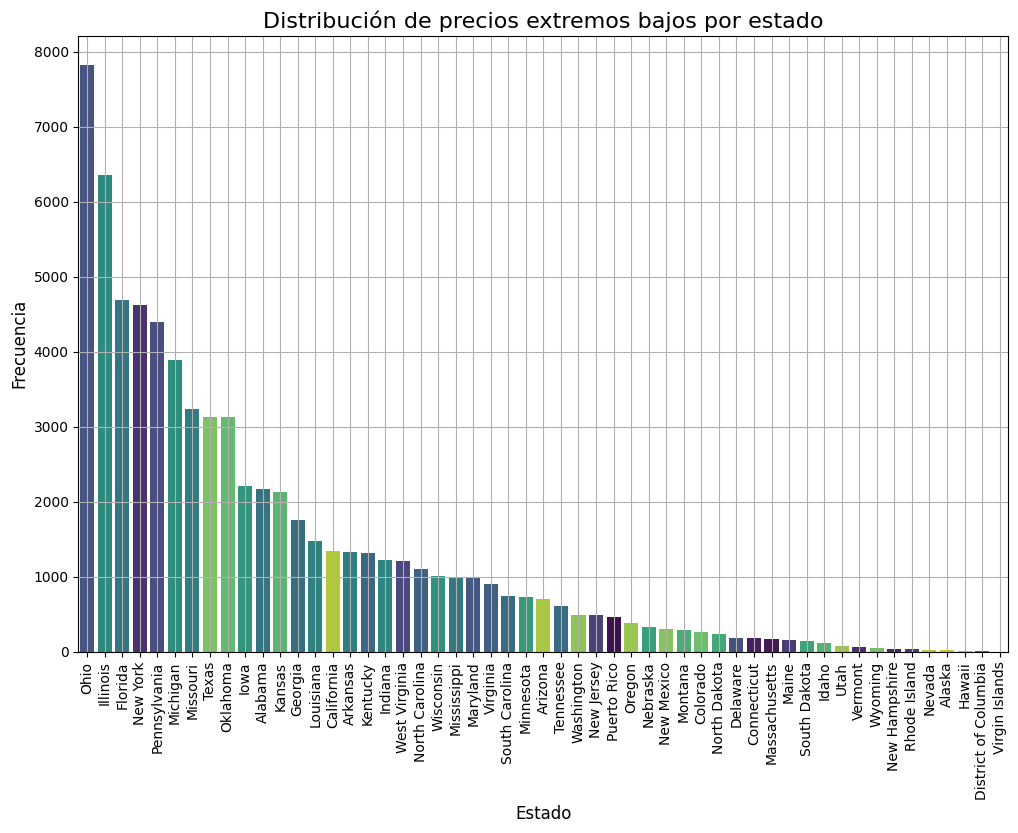

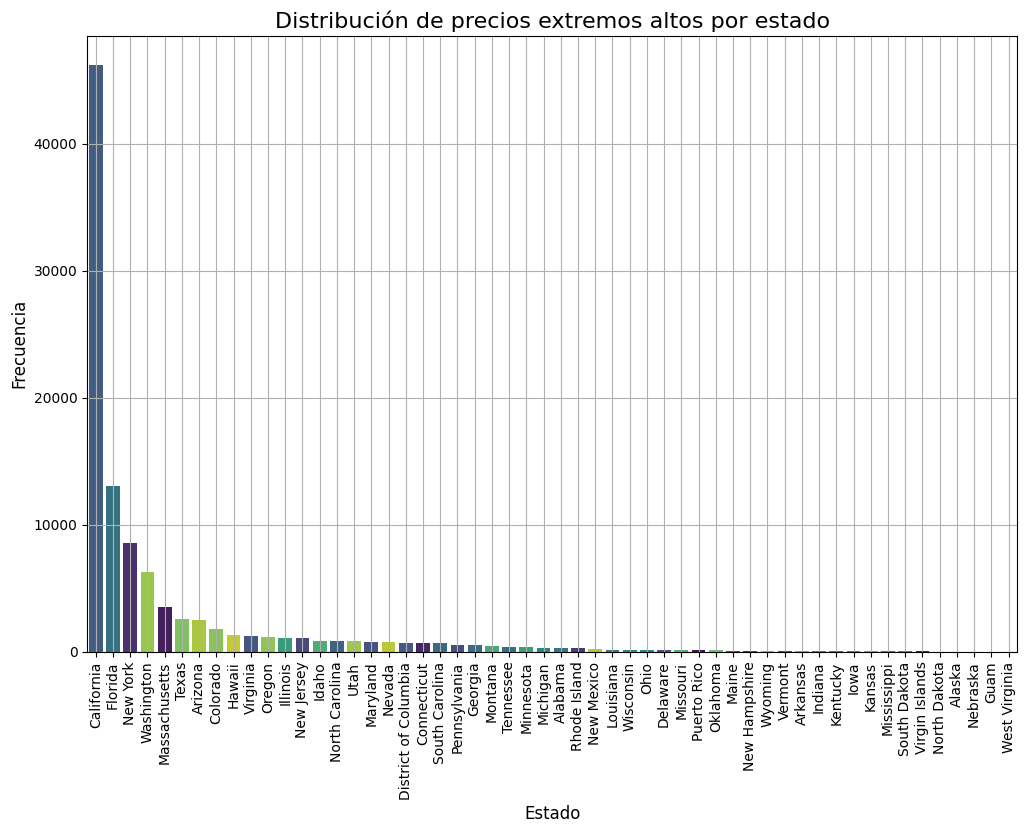

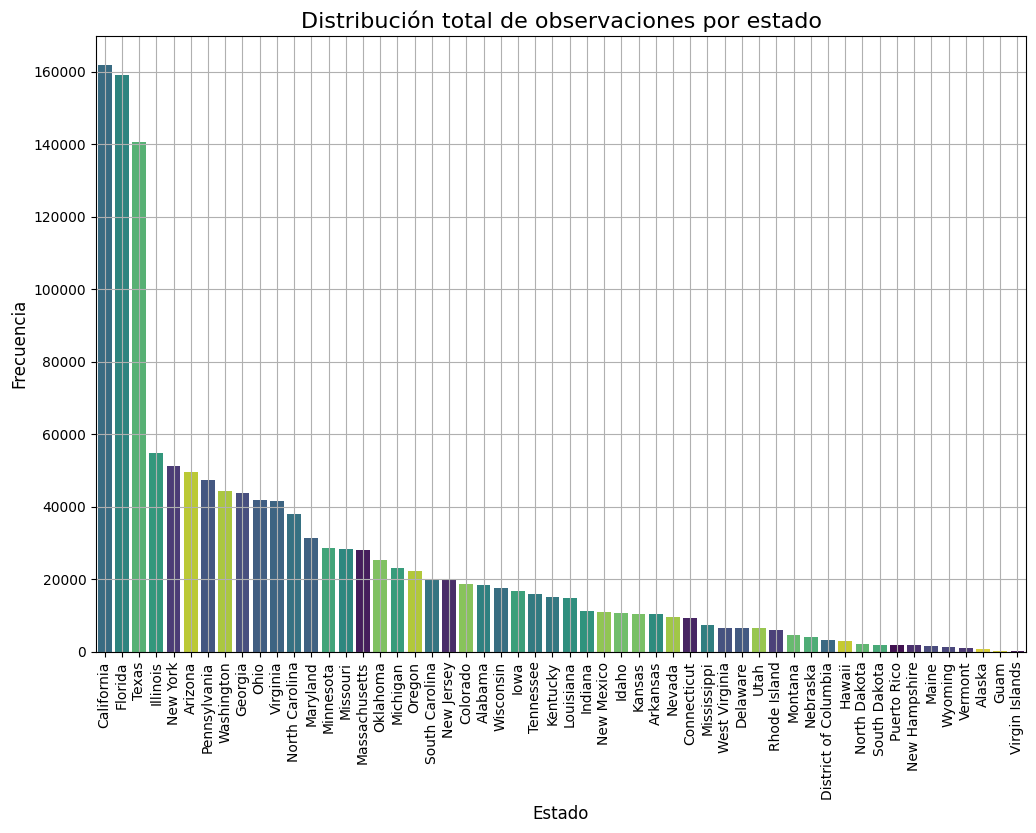

In [141]:
extreme_low = np.exp(11.5)  # Valor original correspondiente a log_price ~ 11.5
extreme_high = np.exp(13.75)  # Valor original correspondiente a log_price ~ 14.0

# Mostrar las filas con esos valores extremos
df_extremes = df_cleaned[(df_cleaned['price'] <= extreme_low) | (df_cleaned['price'] >= extreme_high)]
display(df_extremes[['price', 'log_price', 'state']])
df_extremes.groupby('state').size().reset_index(name='frequency')

# Filtrar los datos extremos bajos y altos
df_extreme_low = df_cleaned[df_cleaned['price'] <= extreme_low]
df_extreme_high = df_cleaned[df_cleaned['price'] >= extreme_high]

# Muestra un grafico de barras para la distribucion por estado de precios extremos bajos
plot_state_distribution(df_extreme_low, 'state', 'Distribución de precios extremos bajos por estado')

# Muestra un grafico de barras para la distribucion por estado de precios extremos altos
plot_state_distribution(df_extreme_high, 'state', 'Distribución de precios extremos altos por estado')

# Muestra un grafico de barras para la distribucion por estado de todas las observaciones
plot_state_distribution(df_cleaned, 'state', 'Distribución total de observaciones por estado')


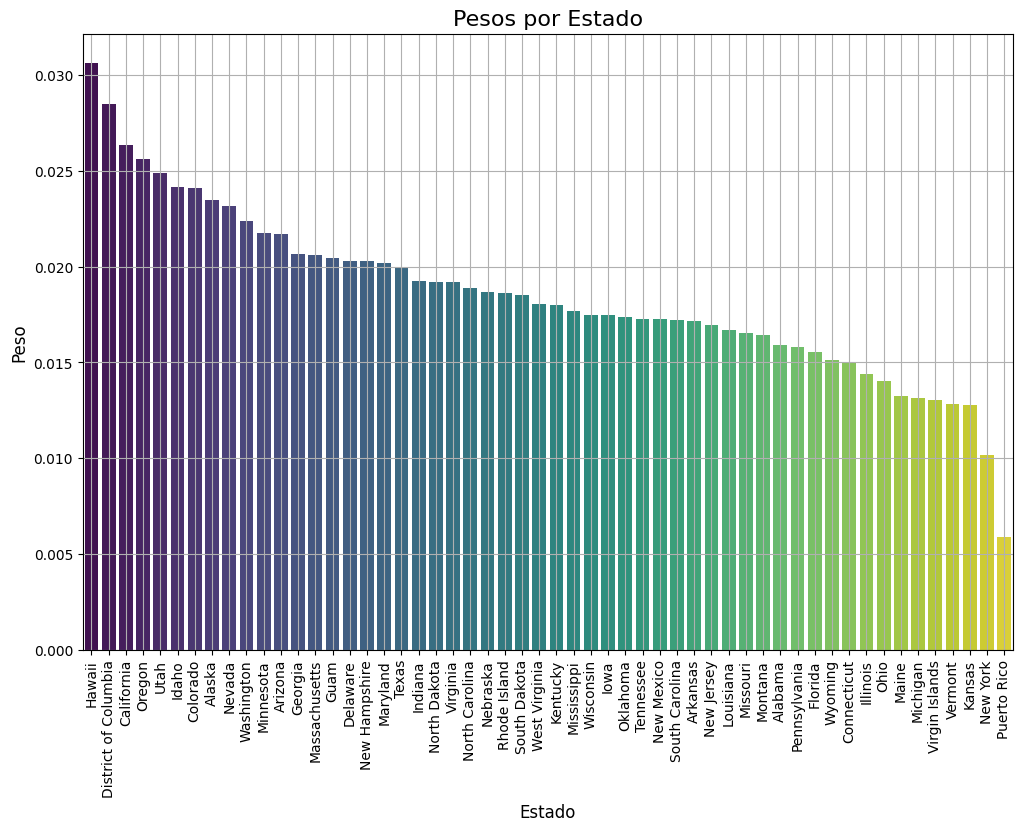

In [142]:
state_stats = df_cleaned.groupby('state')['price'].agg(['median', 'std']).reset_index()

state_stats['weight'] = state_stats['median'] / state_stats['std']

state_stats['weight'] = state_stats['weight'] / state_stats['weight'].sum()

df_cleaned = df_cleaned.merge(state_stats[['state', 'weight']], on='state', how='left')

weights_by_state = df_cleaned.groupby('state')['weight'].max().sort_values(ascending=False).reset_index()

# Crear el gráfico de barras para los pesos por estado
plt.figure(figsize=(12, 8))
sns.barplot(data=weights_by_state, x='state', y='weight', hue='state', palette='viridis')
plt.title('Pesos por Estado', fontsize=16)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Peso', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [148]:

df_cleaned_dummies = pd.get_dummies(df_cleaned, columns=['state'], drop_first=True)
X = df_cleaned_dummies.drop(columns=['price', 'log_price', 'status', 'prev_sold_date', 'weight', 'house_size'])
y = df_cleaned_dummies['log_price']

X = X.astype(float)

y = pd.to_numeric(y, errors='coerce')

X_sm = sm.add_constant(X)
model_wls = sm.WLS(y, X_sm, weights=df_cleaned_dummies['weight'].loc[X.index]).fit()

# Imprimir el resumen del modelo
print(model_wls.summary())

                            WLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.579
Model:                            WLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                 3.259e+04
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        08:22:01   Log-Likelihood:            -7.5970e+05
No. Observations:             1351305   AIC:                         1.520e+06
Df Residuals:                 1351247   BIC:                         1.520e+06
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [144]:
X_bed = df_cleaned[['bed']].astype(float).dropna()  # Asegurarse de que sea float y eliminar NaN
y_bed = df_cleaned['log_price'].loc[X_bed.index]  # Alinear y con X_bed

# Agregar una constante
X_bed_sm = sm.add_constant(X_bed)

# Ajustar el modelo
model_bed = sm.WLS(y_bed, X_bed_sm, weights=df_cleaned['weight'].loc[X_bed.index]).fit()

# Imprimir el resumen
print("\nModelo solo con el número de cuartos:")
print(model_bed.summary())


Modelo solo con el número de cuartos:
                            WLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.075
Model:                            WLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                 1.090e+05
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:03:30   Log-Likelihood:            -1.2917e+06
No. Observations:             1351305   AIC:                         2.583e+06
Df Residuals:                 1351303   BIC:                         2.583e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [145]:
X_size = df_cleaned[['log_house_size']].astype(float).dropna()  # Asegurarse de que sea float y eliminar NaN
y_size = df_cleaned['log_price'].loc[X_size.index]  # Alinear y con X_size

# Agregar una constante
X_size_sm = sm.add_constant(X_size)

# Ajustar el modelo
model_size = sm.WLS(y_size, X_size_sm, weights=df_cleaned['weight'].loc[X_size.index]).fit()

# Imprimir el resumen
print("\nModelo solo con el tamaño de la casa:")
print(model_size.summary())


Modelo solo con el tamaño de la casa:
                            WLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.214
Model:                            WLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                 3.671e+05
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:03:31   Log-Likelihood:            -1.1817e+06
No. Observations:             1351305   AIC:                         2.363e+06
Df Residuals:                 1351303   BIC:                         2.363e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const